# Library imports and directory mount

In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
import cv2, gc, glob, joblib, os, random, sys, warnings

from google.colab import drive

from tensorflow.keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from skimage.transform import resize

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore') 

sns.set() # for ploting

drive.mount('/content/gdrive')

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
!python --version

Mounted at /content/gdrive
Python 3.10.11


## Configuration variables

Index | Recommended configuration
:---: | :---:
1 | Rotation up to 20º<br>shear up to 15º<br>Horizontal and vertical flip<br>Vertical and horizontal shift up to 20%<br>Zoom out up to 20%
2 | Rotation up to 15º<br>Vertical and horizontal flip<br>Image resize up to 10%

In [2]:
### Environment
csvMetadataPath = "/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/HAM10000_metadata.csv" # "HAM10000_metadata.csv"
imagesPath = "gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/" # "images"
savePath = "/content/gdrive/MyDrive/PUC/TCC/Notebooks/"
saveName = "xceptionRaw"

### Height and weight of images to be crop
h, w = 224, 224

### Model architecture
architecture = "xception" # convNeXt | resNetV2 | xception

### Transfer learning from imagenet
transferLearning = False
freezeLayers = False

### Remove duplicates
removeDuplicates = True # 0 = 10015, 1 = 7470

### Segmentation
segmentation = False

### Data augmentation
dataAugmentation = False
rotation = .45
widthShift, heightShift = .1, .1
channelShift = .15
shear = .2
zoom = .25
hFlip, vFlip = True, True
fill = 'nearest' # constant, nearest, reflect, wrap
cval = .5 # case the previous is constant
bright = [.6,1.4]

### Normalization
featureCenter = False
sampleCenter = False
featureStdNorm = False
sampleStdNorm = False
zcaWhitening = False
### Separate from imageDataGenerator
standardScalerNorm = False
minMaxScalerNorm = False

### Model configuration
epochs = 5
batchSize = 8
customOptimizer = False
useCallback = False

cancerType = {
    'akiec': 0, # 0.0 - 'Doenca de Bowens'
    'bcc': 1, # 1.0 - 'Carcinoma basocelular'
    'bkl': 2, # 2.0 - 'Keratose benigna'
    'df': 3, # 3.0 - 'Dermatofibroma'
    'vasc': 4, # 4.0 - 'Lesao vascular'
    'mel': 5, # 5.0 - 'Melanoma'
    'nv': 6  # 6.0 - 'Nevo melanocitico'
}
totalClasses = len(cancerType)

# Dataset import (CSV Metadata)

In [3]:
datasetMetadata = pd.read_csv(csvMetadataPath)
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization']) # Non-utilized columns
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata.head()

,lesionId,imageId,cancerId
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [4]:
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['lesionId'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image
datasetMetadata['duplicate'].value_counts()
del uniqueLesions

Removing Duplicates

In [5]:
if removeDuplicates: # Adjusted to get only one of the duplicates and non duplicates
    datasetMetadata = datasetMetadata[~((datasetMetadata['lesionId'].duplicated()) & (datasetMetadata['duplicate']))]
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,bkl,True
2,HAM_0002730,ISIC_0026769,bkl,True
4,HAM_0001466,ISIC_0031633,bkl,True
6,HAM_0002761,ISIC_0029176,bkl,True
8,HAM_0005132,ISIC_0025837,bkl,True


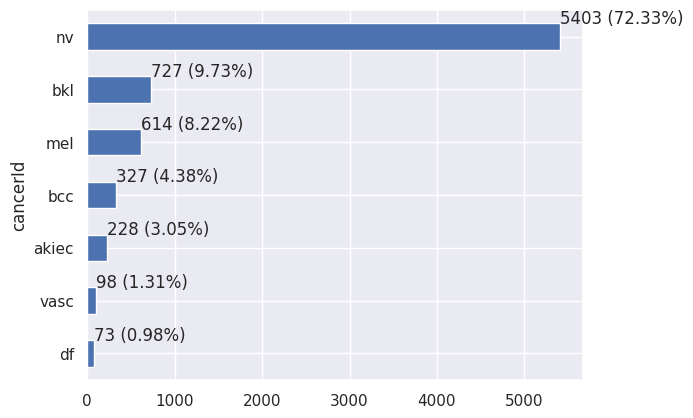

cancerId
df         73
vasc       98
akiec     228
bcc       327
mel       614
bkl       727
nv       5403
dtype: int64
Total:  7470


In [6]:
labelSize = datasetMetadata.groupby('cancerId').size().sort_values() # Sort and order every cancer class

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/datasetMetadata.shape[0]*100, 2)) + '%)') # Set the percentage of each cancer class

plt.show()

print(labelSize)
print("Total: ", labelSize.sum())
del labelSize

In [7]:
datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType) # Map each class into an integer
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,2,True
2,HAM_0002730,ISIC_0026769,2,True
4,HAM_0001466,ISIC_0031633,2,True
6,HAM_0002761,ISIC_0029176,2,True
8,HAM_0005132,ISIC_0025837,2,True


# Dataset import (Imgs)

Path to the dataset images

"/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/<imgId>.jpg"

In [8]:
images = []
loadedImages = 0

for index, row in datasetMetadata.iterrows():
    img = cv2.imread(''.join([imagesPath, row['imageId'], '.jpg'])) # Collect the image from drive
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Invert color BGR => RGB
    img = cv2.resize(img, (h, w)) # Resize the image according to params provided
    images.append(img)

    loadedImages = loadedImages + 1
    if loadedImages % 1000 == 0:
        print(loadedImages)
del loadedImages, img

KeyboardInterrupt: ignored

In [ ]:
plt.imshow(images[0])
print(len(images))
print(datasetMetadata.iloc[0])
print(images[0].shape)
plt.show()

# Images treatment


1. Split train/val/test sets
1. Data augmentation (training set)
1. Segmentation (all sets)
1. Np array
1. Normalization (all sets, fit by training)
1. Reshape / toCategorical

Spliting in training, validation and test balancing the batches by the cancer id:

Train set = 70%

Validation set = 10%

Test set = 20%

In [ ]:
XTrainVal, XTest, YTrainVal, YTest = train_test_split(images, datasetMetadata['cancerId'], test_size=0.2, train_size=0.8, stratify=datasetMetadata['cancerId'])
del images, datasetMetadata
XTrain, XVal, YTrain, YVal = train_test_split(XTrainVal, YTrainVal, test_size = 0.125, train_size = 0.875, stratify = YTrainVal)
del XTrainVal, YTrainVal

print('Train set size: ', YTrain.size)
print('Validation set size: ', YVal.size)
print('Test set size: ', YTest.size)

Information of each class in every set

In [ ]:
labelSize = YTrain.value_counts().sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTrain.shape[0]*100, 2)) + '%)')

plt.show()

labelSize = YVal.value_counts().sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YVal.shape[0]*100, 2)) + '%)')

plt.show()

labelSize = YTest.value_counts().sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTest.shape[0]*100, 2)) + '%)')

plt.show()
del labelSize, ax

Data augmentation

Only be applied in the training set

In [ ]:
if dataAugmentation: # TODO: test
    datagen = ImageDataGenerator(
        # Normalizations
        featurewise_center = featureCenter,
        samplewise_center = sampleCenter,
        featurewise_std_normalization = featureStdNorm,
        samplewise_std_normalization = sampleStdNorm,
        zca_whitening = zcaWhitening,
        # Image modifications
        rotation_range = rotation,
        zoom_range = zoom,
        channel_shift_range = channelShift,
        fill_mode = fill,
        cval = cval,
        width_shift_range = widthShift,
        height_shift_range = heightShift,
        horizontal_flip = hFlip,
        brightness_range = bright,
        shear_range = shear,
        vertical_flip = vFlip
    )

    """
    YTrain.value_counts().sort_values()
    total_samples = 5403 + 727 + 614 + 327 + 228 + 98 + 73 // YTrain.value_counts()

    class_weights = {
        0: total_samples / 5403,
        1: total_samples / 727,
        2: total_samples / 614,
        3: total_samples / 327,
        4: total_samples / 228,
        5: total_samples / 98,
        6: total_samples / 73
    }


    class_counts = YTrain.value_counts().sort_values()

    total_samples = class_counts.sum()

    class_weights = {
        class_label: total_samples / count
        for class_label, count in class_counts.items()
    }

    """

    print(XTrain.shape)
    print(XTrain.size)
    if featureCenter or featureStdNorm or zcaWhitening:
        datagen.fit(XTrain)
    print(XTrain.shape)
    print(XTrain.size)
    XTrain, YTrain, weights = datagen.flow(XTrain, YTrain, batch_size = batchSize) # TODO: review batchSize

Segmentation

In [ ]:
def segmentImg(img, alpha = 1.0, kernelMask = (5, 5), kernelSoftMask = (21, 21)):
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    softenedImg = cv2.GaussianBlur(grayImg, kernelMask, 0)                                # Apply softened filter to reduce noise
    _, mask = cv2.threshold(softenedImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # Thresholding algorithm to create mask
    softenedMask = cv2.GaussianBlur(mask, kernelSoftMask, 0)                              # Smoothing filter
    segmentedImg = cv2.bitwise_and(img, img, mask = softenedMask)                         # Apply mask
    beta = 1.0 - alpha                                                                    # Beta = weight for original image, alpha = Weight for segmented image - 0 for highlight only the lesion, 1 for original image
    return cv2.addWeighted(img, alpha, segmentedImg, beta, 0)                             # Merge segmented image and original image weighted

def segmentImgList(imgs):
    for i in range(len(imgs)):
        imgs[i] = segmentImg(imgs[i])
    return imgs

if segmentation:
    XTrain = segmentImgList(XTrain)
    XVal = segmentImgList(XVal)
    XTest = segmentImgList(XTest)

Transform datasets into np arrays

In [ ]:
XTrain = np.array(XTrain)
XTrain = XTrain.reshape(XTrain.shape[0], h * w * 3) # 4d -> 2d

XVal = np.array(XVal)
XVal = XVal.reshape(XVal.shape[0], h * w * 3) # 4d -> 2d

XTest = np.array(XTest)
XTest = XTest.reshape(XTest.shape[0], h * w * 3) # 4d -> 2d

Normalization

In [ ]:
if minMaxScalerNorm:
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(np.asarray(XTrain))

    XTrain = minMaxScaler.transform(XTrain)
    XVal = minMaxScaler.transform(XVal)
    XTest = minMaxScaler.transform(XTest)
elif standardScalerNorm:
    standardScaler = StandardScaler()
    standardScaler.fit(np.asarray(XTrain))

    XTrain = standardScaler.transform(XTrain)
    XVal = standardScaler.transform(XVal)
    XTest = standardScaler.transform(XTest)

print(np.shape(XTest))
print(np.shape(XTrain))
print(np.shape(XVal))
print(YTrain.head())

Resize and input adaptation

In [ ]:
print(XTrain.shape[0])
print(XVal.shape[0])
print(XTest.shape[0])

XTrain = XTrain.reshape(XTrain.shape[0], h, w, 3).astype('float32')
XVal = XVal.reshape(XVal.shape[0], h, w, 3).astype('float32')
XTest = XTest.reshape(XTest.shape[0], h, w, 3).astype('float32')

YTrain = np_utils.to_categorical(YTrain)
YVal = np_utils.to_categorical(YVal)
YTest = np_utils.to_categorical(YTest)

print(XTrain[0].shape)
XTrain.dtype

In [ ]:
#for name, var in globals().copy().items():
#    print(f"{name}: {sys.getsizeof(var)} bytes")

# Model training

Loading pre treined model

In [ ]:
with tf.device('/GPU:0'): # Using GPU processing on model
    match architecture:
        case "convNeXt":
            model = tf.keras.applications.ConvNeXtBase(classes = totalClasses,
                                                       include_top = False,
                                                       input_shape = (h,w,3),
                                                       weights = 'imagenet' if transferLearning else None)
        case "resNetV2":
            model = tf.keras.applications.ResNet50V2(classes = totalClasses,
                                                     include_top = False,
                                                     input_shape = (h,w,3),
                                                     weights = 'imagenet' if transferLearning else None)
        case "xception":
            model = tf.keras.applications.Xception(classes = totalClasses,
                                                   include_top = False,
                                                   input_shape = (h,w,3),
                                                   weights = 'imagenet' if transferLearning else None)
        case _:
            raise Exception("model not configured or non existent")

    if freezeLayers:
        for layer in model.layers:
            layer.trainable = False

    model = tf.keras.Model(inputs = model.input, outputs = tf.keras.layers.Dense(totalClasses, activation = 'softmax')(tf.keras.layers.Flatten()(model.output)))

    if customOptimizer:
        model.compile(optimizer = AdamW(amsgrad = True,
                          beta_1 = 0.9 if transferLearning else 0.8,
                          beta_2 = 0.999 if transferLearning else 0.99,
                          lr = 0.00001 if transferLearning else 0.001,
                          weight_decay = 0.04 if dataAugmentation else 0.0004),
                      loss = "categorical_crossentropy",
                      metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    else:
        model.compile(optimizer = "adam",
                      loss = "categorical_crossentropy",
                      metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
gc.collect()
plt.close('all')

Training the model

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(batch_size = batchSize, 
                        callbacks = [EarlyStopping(min_delta = 0.001, monitor = 'val_loss')] if useCallback else None,
                        class_weight = None # TODO: set the weights
                        epochs = epochs, 
                        validation_data = (XVal, YVal), 
                        validation_freq = list(range(1, epochs + 1, 2)), # Only apply validation in odd epochs
                        verbose = 2,
                        x = XTrain,
                        y = YTrain) 

In [ ]:
del XTrain, YTrain
gc.collect()

# Statistics

General eficiency

In [ ]:
YPredicted = model.predict(XTest)
print('Test set evaluation: ', model.evaluate(XTest, YTest, verbose = 0))
print('Validation set evaluation: ', model.evaluate(XVal, YVal, verbose = 0))

Training epochs statistics

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.title('Model Training History')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.show()

Confusion matrix

In [ ]:
cm = confusion_matrix(YTest.argmax(axis = 1), YPredicted.argmax(axis = 1))

labels = ['Bowens disease',
          'Basal cell carcinoma',
          'Benign keratosis',
          'Dermatofibroma',
          'Vascular lesion',
          'Melanoma',
          'Melanocytic nevi']
dfCm = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (15, 15))
sns.set(font_scale = 1.4) # Label size
sns.heatmap(dfCm, annot = False, cmap="Blues", annot_kws = {"size": 14}) # Font size

for i in range(totalClasses):
    for j in range(totalClasses):
        text = plt.text(j + 0.5, i + 0.5, f"{cm[i, j]:0d} ({cm[i, j] / cm[i].sum() * 100:.2f}%)", 
                        va="center", 
                        ha="center",
                        color="orange",
                        fontsize=10)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
del ax, cm, dfCm
gc.collect()

Metrics

In [ ]:
metrics = {
    'Precision': precision_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),
    'F1-score': f1_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),
    'ROC AUC': roc_auc_score(YTest, YPredicted, average=None),
    'Recall': recall_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None)
}

cmMulti = multilabel_confusion_matrix(YTest.argmax(axis=1), YPredicted.argmax(axis=1))
specificity = []
for i in range(len(cmMulti)):
    tn = cmMulti[i][0][0]
    specificity.append(tn / (tn + cmMulti[i][0][1]))
metrics[f'Specificity'] = specificity

metrics[f'Confusion_Matrix'] = cmMulti
del cmMulti, specificity

In [ ]:
for metric, values in metrics.items():
    print(metric + ':\n')
    if 'Confusion_Matrix' in metric:
        for id, value in enumerate(values):
          sns.set(font_scale = 1.4) # Label size
          percentages = value / np.sum(value, axis = 1, keepdims = True)
          sns.heatmap(value, annot = False, cmap = "Blues")
          ax = plt.gca()
          for i in range(len(value)):
              for j in range(len(value)):
                  ax.text(j + 0.5, i + 0.5, f'{value[i, j]:0d} ({percentages[i, j]*100:.0f}%)', 
                          ha='center', 
                          va='center', 
                          color='orange', 
                          fontsize = 14)
          ax.set_yticklabels(['True', 'False'])
          ax.set_xticklabels(['True', 'False'])
          plt.title(f'{labels[id]}')
          plt.ylabel('True label')
          plt.xlabel('Predicted label')
          plt.show()
    else:
        for id, value in enumerate(values):
            df = pd.DataFrame({'Label': labels, 'Value': values})
        print(df.to_string(index = False, col_space = 10, justify = 'center'))
    print('\n')

Saving model into google drive

In [ ]:
model.save(''.join([savePath, saveName, '.h5']))
if minMaxScalerNorm:
    joblib.dump(minMaxScaler, ''.join([savePath, saveName, 'MMscaler.pkl']))
elif standardScalerNorm:
    joblib.dump(standardScaler, ''.join([savePath, saveName, 'StdScaler.pkl']))